Score Category 0:
H_mean         63.869205
S_mean         59.247254
V_mean        141.570880
I1_mean        45.826219
I2_mean        56.414396
I3_mean        24.577271
L_mean         45.826219
S_lst_mean      5.273337
T_mean        112.828791
Name: 0, dtype: float64


Score Category 1:
H_mean         59.648873
S_mean         66.859117
V_mean        139.686261
I1_mean        45.791436
I2_mean        51.334073
I3_mean        22.715751
L_mean         45.791436
S_lst_mean      5.373644
T_mean        102.668145
Name: 1, dtype: float64


Score Category 2:
H_mean         57.519464
S_mean         71.524723
V_mean        139.252184
I1_mean        45.807985
I2_mean        48.860708
I3_mean        21.836379
L_mean         45.807985
S_lst_mean      5.433682
T_mean         97.721416
Name: 2, dtype: float64


Score Category 3:
H_mean         56.141954
S_mean         75.105693
V_mean        139.041323
I1_mean        45.526977
I2_mean        47.542561
I3_mean        21.386805
L_mean         45.526977


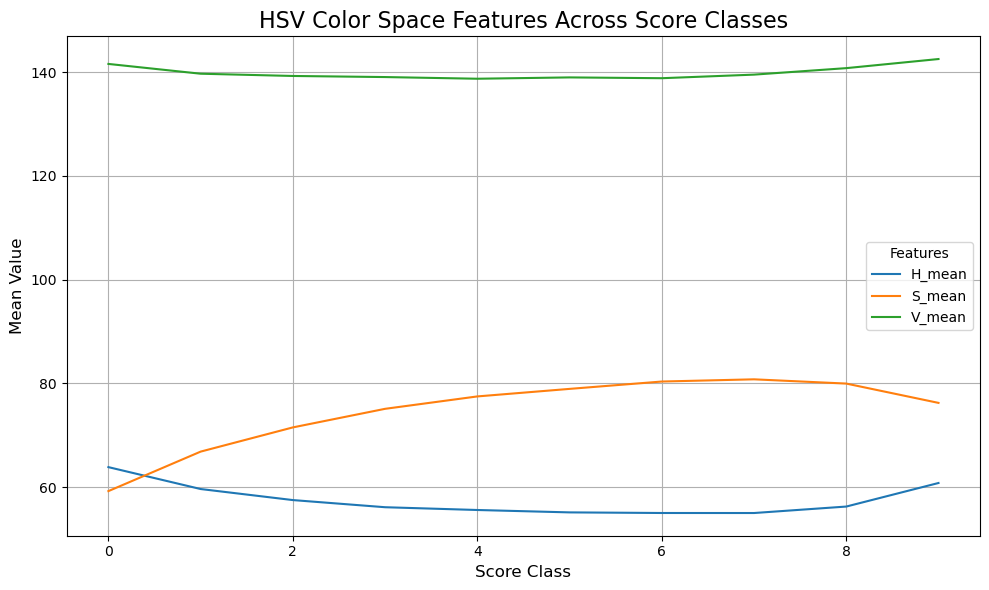

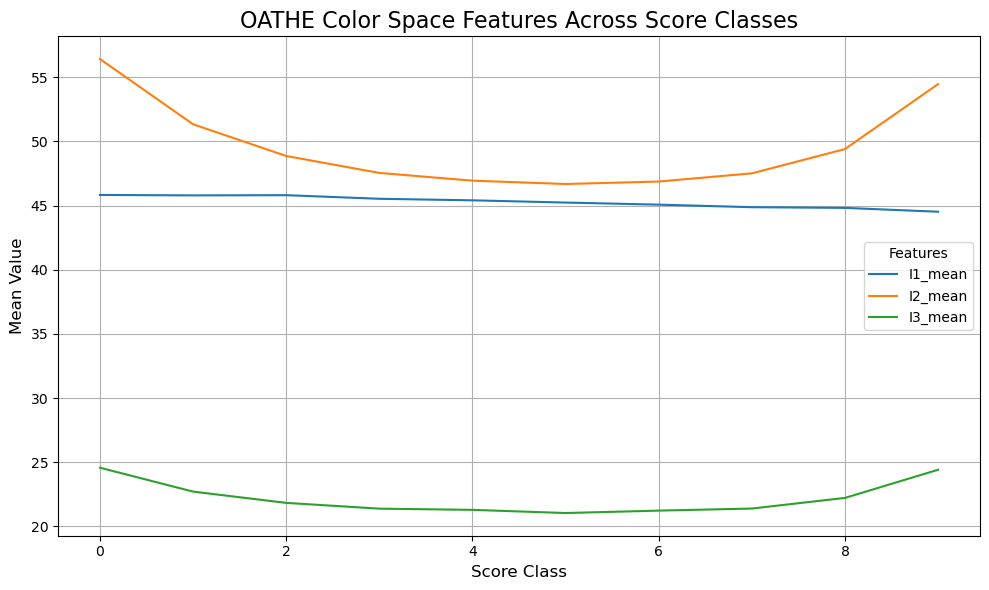

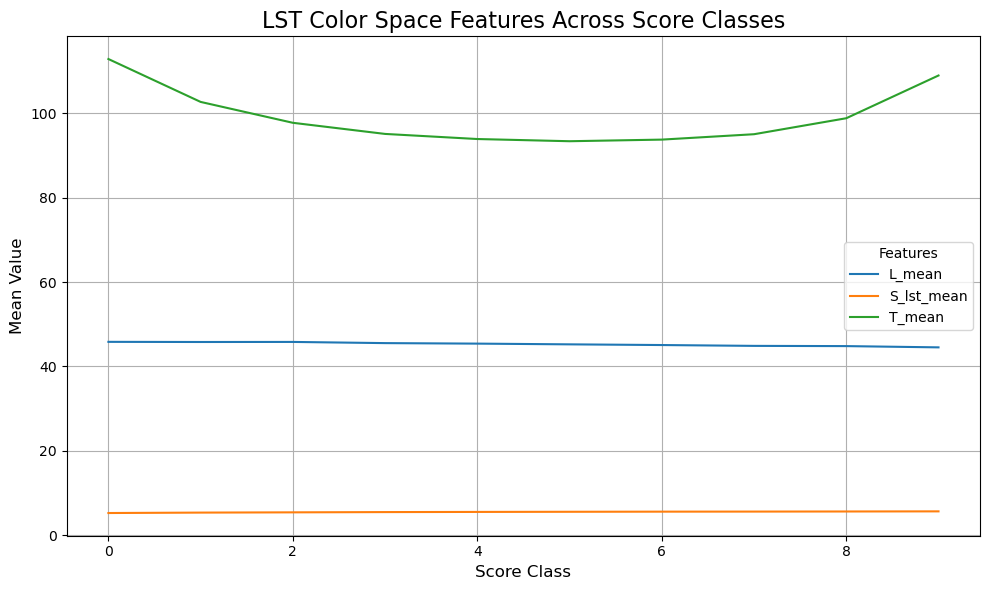

In [3]:
import pandas as pd
from collections import Counter
import os

# Read the score data
df_scores = pd.read_csv('/home/ubuntu/landscape-aesthetics/data/external/scenicornot/scenicornot.metadata.csv')

# Read the color feature data (color space features: H_mean, S_mean, V_mean, etc.)
df_colors = pd.read_csv('/home/ubuntu/landscape-aesthetics/data/external/scenicornot/scenicornot_color_feature.csv')  # Change to the path of your color feature file

# Assume the first column in df_scores is the image name and the 8th column is the score
df_scores = df_scores[['filename', 'average']]  # Extract the columns for image names and scores

# Divide the scores into 10 equal-frequency intervals
df_scores['score_category'] = pd.qcut(df_scores['average'], q=10, labels=False)

df_colors['filename_extracted'] = df_colors['image_path'].apply(os.path.basename)
df_scores['filename_extracted'] = df_scores['filename'].apply(os.path.basename)

# Merge the two dataframes based on the image name
df_merged = pd.merge(df_scores, df_colors, left_on='filename_extracted', right_on='filename_extracted')

# Calculate the mean of each color space feature per score category
color_features = ['H_mean', 'S_mean', 'V_mean', 'I1_mean', 'I2_mean', 'I3_mean', 'L_mean', 'S_lst_mean', 'T_mean']

mean_colors_by_category = df_merged.groupby('score_category')[color_features].mean()

# Output the mean values of the color features for each score category
for category in mean_colors_by_category.index:
    print(f"Score Category {category}:")
    print(mean_colors_by_category.loc[category])
    print("\n")

# Visualize the color features for each score category
import matplotlib.pyplot as plt

hsv_features = ['H_mean', 'S_mean', 'V_mean']

oathe_features = ['I1_mean', 'I2_mean', 'I3_mean']

lst_features = ['L_mean', 'S_lst_mean', 'T_mean']

color_spaces = {
    'HSV': hsv_features,
    'OATHE': oathe_features,
    'LST': lst_features
}

for space_name, features in color_spaces.items():
    plt.figure(figsize=(10, 6))
    for feature in features:
        plt.plot(mean_colors_by_category.index, mean_colors_by_category[feature], label=feature)
    
    plt.title(f'{space_name} Color Space Features Across Score Classes', fontsize=16)
    plt.xlabel('Score Class', fontsize=12)
    plt.ylabel('Mean Value', fontsize=12)
    plt.legend(title='Features')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"/home/ubuntu/landscape-aesthetics/reports/figures/{space_name}.jpg")
    plt.show()



In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

hsv_features = ['H_mean', 'S_mean', 'V_mean']
ohta_features = ['I1_mean', 'I2_mean', 'I3_mean']
lst_features = ['L_mean', 'S_lst_mean', 'T_mean']

color_spaces = {
    'HSV': hsv_features,
    'Ohta': ohta_features,
    'LST': lst_features
}

target_column = 'average'

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import kruskal
import pandas as pd

target_column = 'average'

for space_name, features in color_spaces.items():
    print(f"\n===== Analyzing {space_name} Color Space =====")
    
    # 提取当前颜色空间的特征和目标列
    df_current_space = df_merged[features + [target_column]]
    
    # 1. Spearman Rank 相关系数
    print(f"\nSpearman Correlation with {target_column}:")
    spearman_corr = df_current_space.corr(method='spearman')
    print(spearman_corr[target_column].sort_values(ascending=False))
    
    # 2. ANOVA（方差分析）
    print("\nANOVA (F-value and P-value):")
    for feature in features:
        f_val, p_val = stats.f_oneway(*[df_merged[df_merged[target_column] == score][feature] for score in df_merged[target_column].unique()])
        print(f"{feature}: F-value: {f_val}, P-value: {p_val}")
    
    # 3. Kruskal-Wallis 检验
    print("\nKruskal-Wallis Test (H-statistic and P-value):")
    for feature in features:
        h_stat, p_val = kruskal(*[df_merged[df_merged[target_column] == score][feature] for score in df_merged[target_column].unique()])
        print(f"{feature}: H-statistic: {h_stat}, P-value: {p_val}")
    
    # 4. 线性回归分析
    X = df_merged[features]  
    y = df_merged[target_column] 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("\nLinear Regression Coefficients:")
    for feature, coef in zip(features, model.coef_):
        print(f"{feature}: {coef}")

    mse = mean_squared_error(y_test, y_pred)
    r2 = model.score(X_test, y_test)
    print(f"\nMean Squared Error (MSE): {mse}")
    print(f"R^2 Score: {r2}")



===== Analyzing HSV Color Space =====

Spearman Correlation with average:
average    1.000000
S_mean     0.204747
V_mean     0.020143
H_mean    -0.084403
Name: average, dtype: float64

ANOVA (F-value and P-value):
H_mean: F-value: 4.925447333217639, P-value: 0.0
S_mean: F-value: 8.555980738915313, P-value: 0.0
V_mean: F-value: 1.435978435458261, P-value: 1.3826843718722136e-30

Kruskal-Wallis Test (H-statistic and P-value):
H_mean: H-statistic: 8372.640583055547, P-value: 0.0
S_mean: H-statistic: 15184.50595013918, P-value: 0.0
V_mean: H-statistic: 2549.3143381226796, P-value: 1.8851475288453603e-30

Linear Regression Coefficients:
H_mean: -0.0010898092597936815
S_mean: 0.010891115997390103
V_mean: 0.0034879971616816993

Mean Squared Error (MSE): 2.445168191926806
R^2 Score: 0.03948247114759296

===== Analyzing Ohta Color Space =====

Spearman Correlation with average:
average    1.000000
I3_mean   -0.022024
I2_mean   -0.046657
I1_mean   -0.075224
Name: average, dtype: float64

ANOVA 

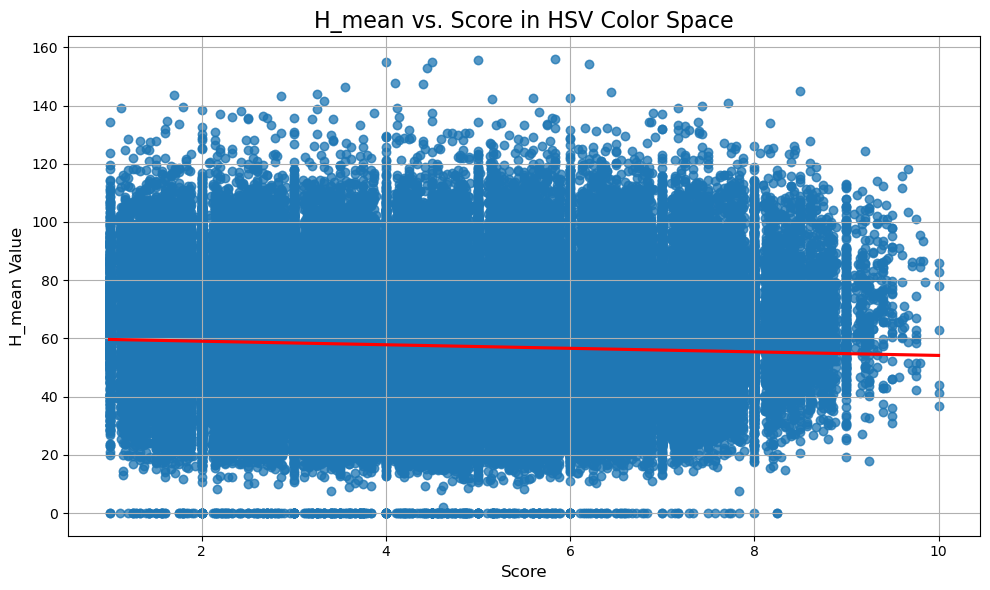

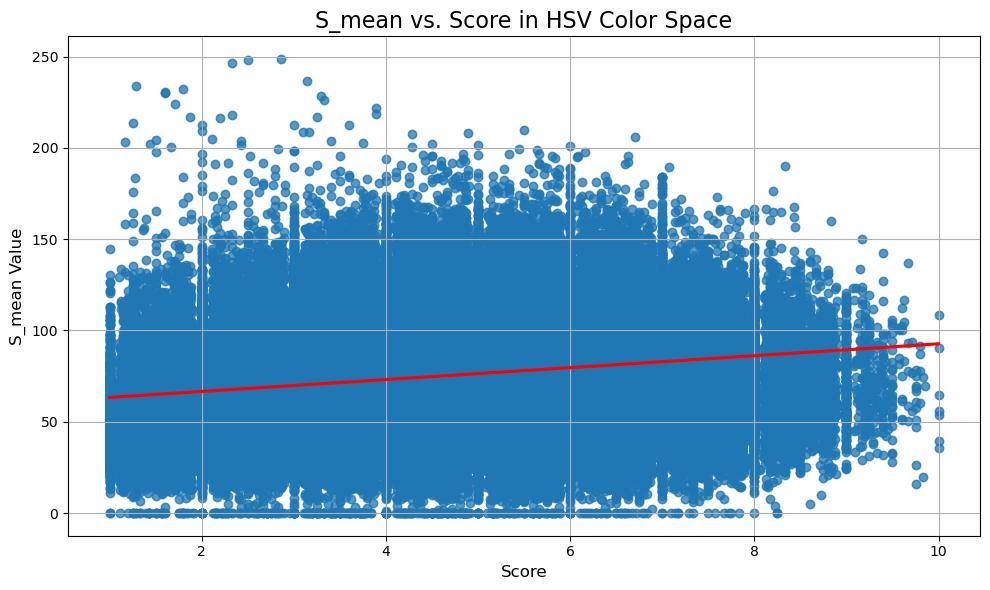

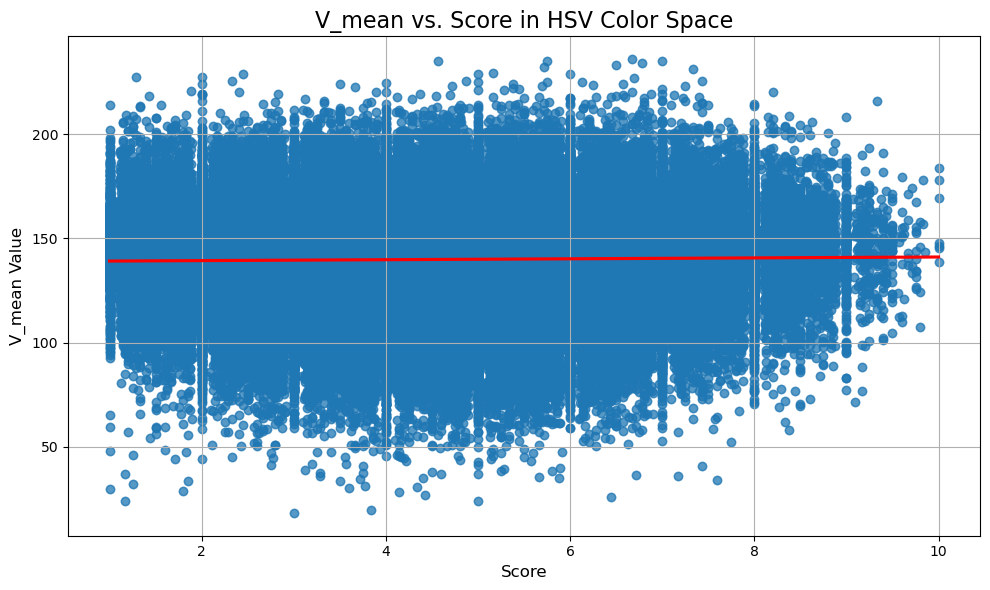

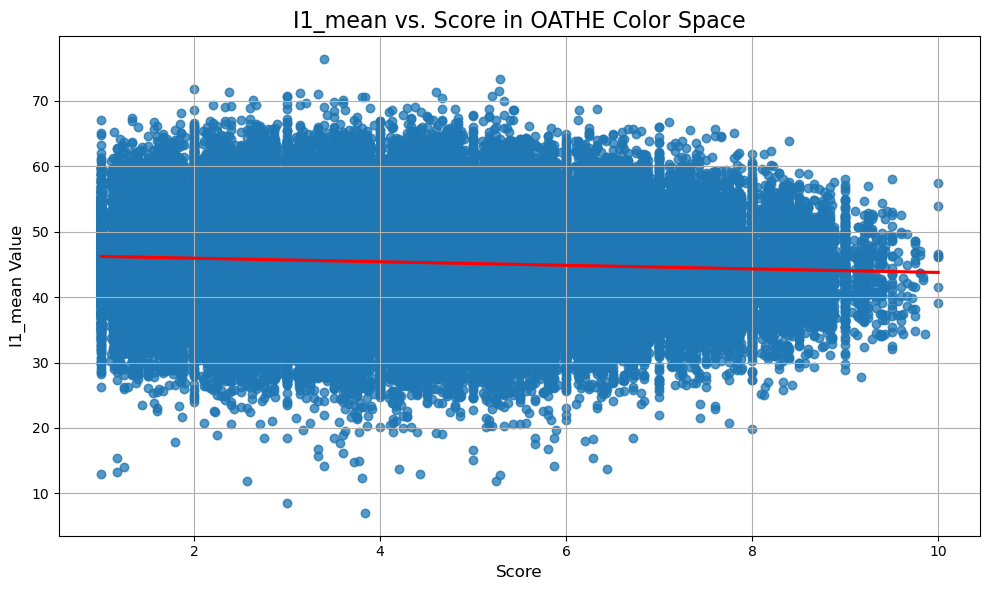

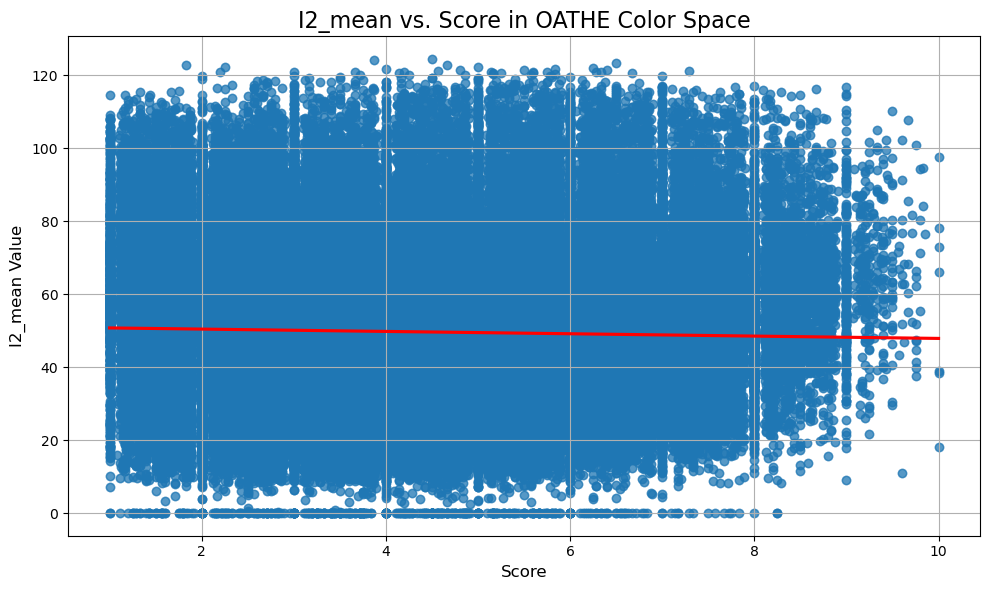

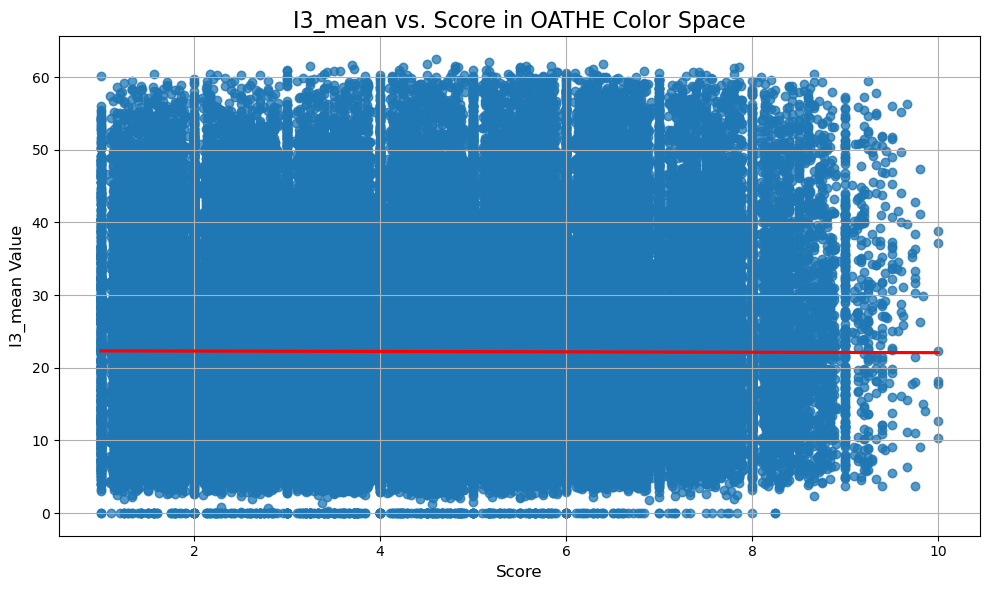

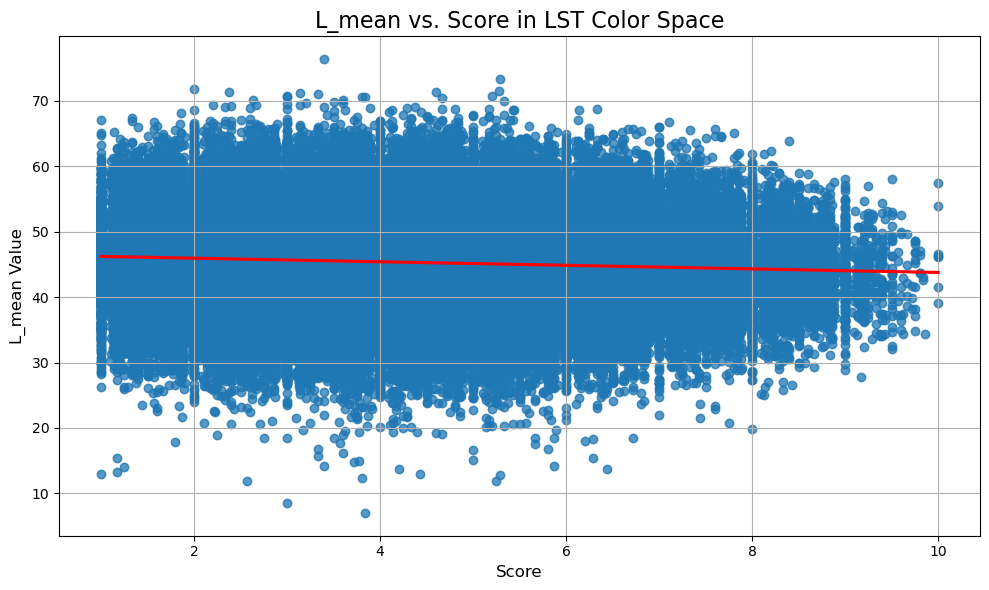

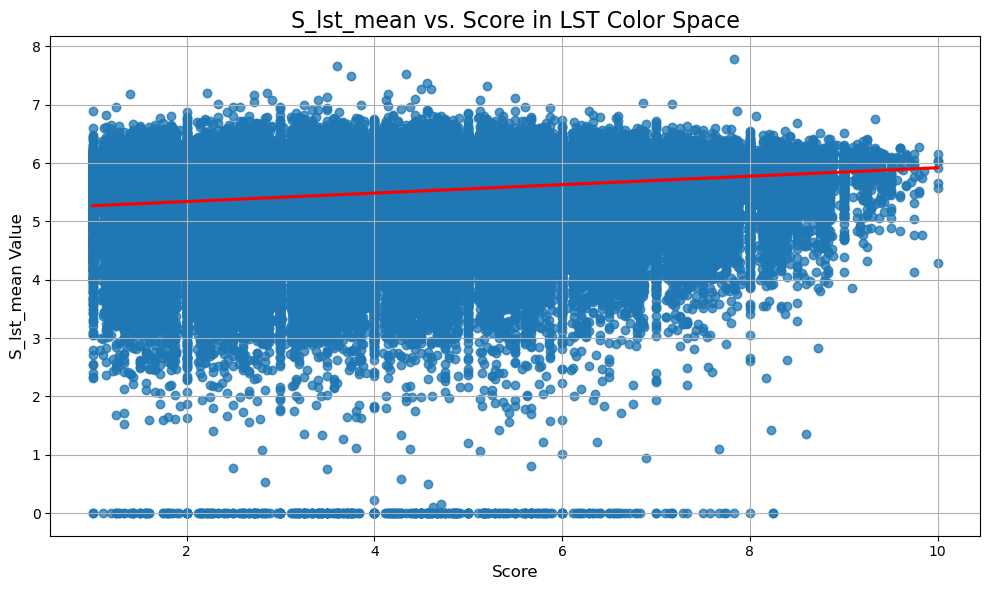

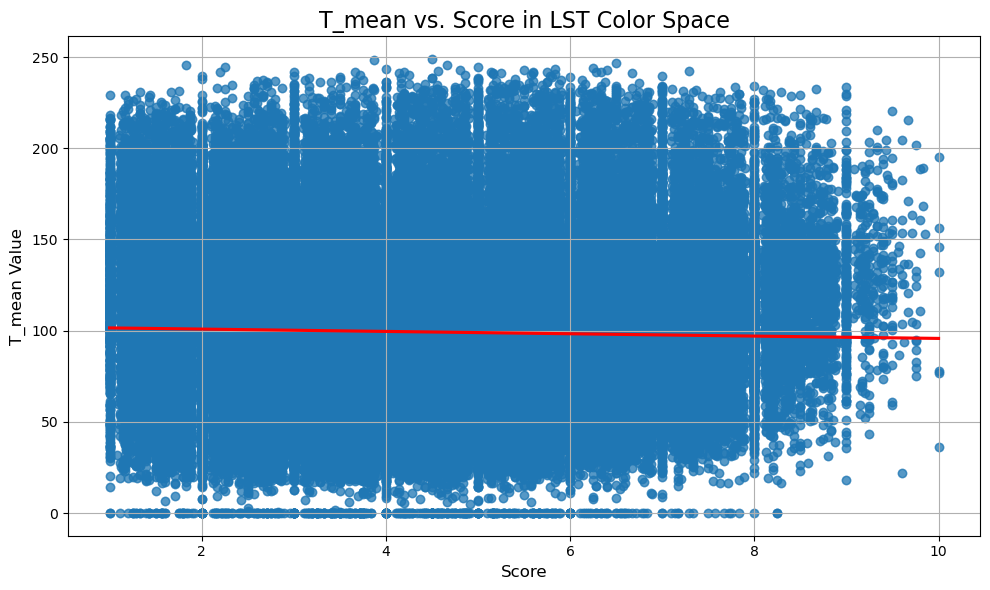

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# 定义颜色空间的特征
hsv_features = ['H_mean', 'S_mean', 'V_mean']
oathe_features = ['I1_mean', 'I2_mean', 'I3_mean']
lst_features = ['L_mean', 'S_lst_mean', 'T_mean']

color_spaces = {
    'HSV': hsv_features,
    'OATHE': oathe_features,
    'LST': lst_features
}

# 对每个颜色空间和特征画散点图
for space_name, features in color_spaces.items():
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.regplot(x=df_merged['average'], y=df_merged[feature], scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
        # 绘制特征与评分的散点图
        plt.scatter(df_merged['average'], df_merged[feature], alpha=0.5)
        
        plt.title(f'{feature} vs. Score in {space_name} Color Space', fontsize=16)
        plt.xlabel('Score', fontsize=12)
        plt.ylabel(f'{feature} Value', fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        
        # 保存图像
        plt.savefig(f"/home/ubuntu/landscape-aesthetics/reports/figures/scatter_{space_name}_{feature}.jpg")
        plt.show()


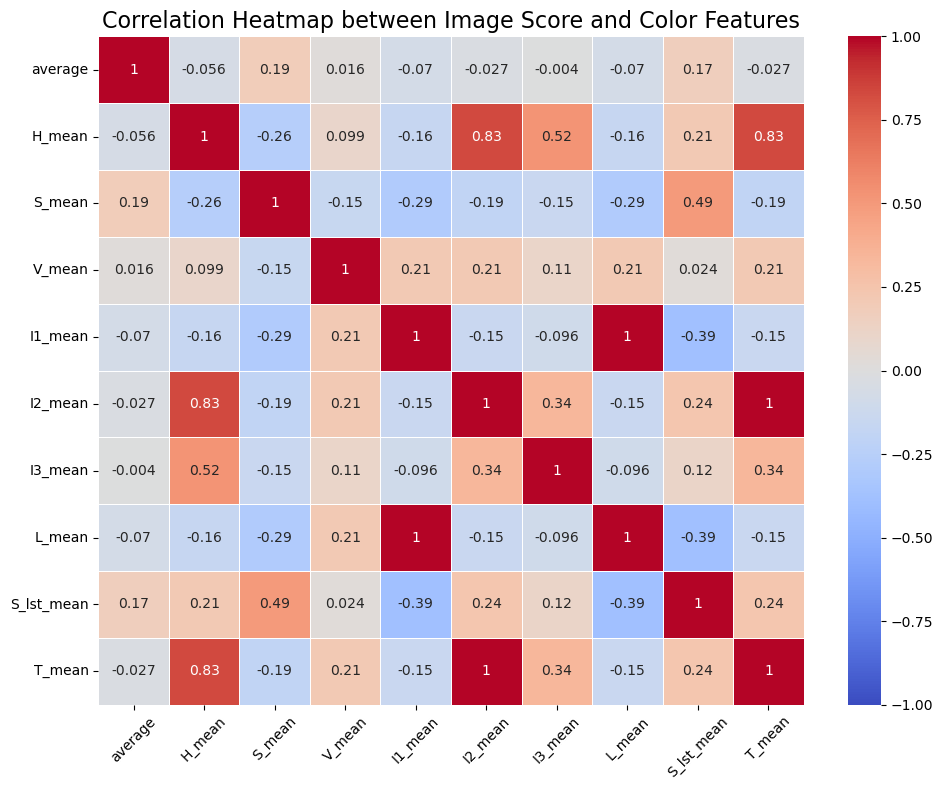

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

color_features = ['H_mean', 'S_mean', 'V_mean', 'I1_mean', 'I2_mean', 'I3_mean', 'L_mean', 'S_lst_mean', 'T_mean']
df_corr = df_merged[['average'] + color_features]

correlation_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

plt.title('Correlation Heatmap between Image Score and Color Features', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig("/home/ubuntu/landscape-aesthetics/reports/figures/correlation_heatmap.jpg")
plt.show()
